In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
! unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip

Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               


## Fetching the Glove Embeddings

In [3]:
import urllib.request 

urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x786d2dd600d0>)

In [4]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
data = pd.read_csv("train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Storing the glove embedding values into a dict for easy access

In [6]:
glove_dict = dict()
f = open('glove.6B.300d.txt')
for line in f:
    tokens = line.split(" ")
    glove_dict[tokens[0]] = np.array(tokens[1:],dtype=float)

In [7]:
from sklearn.model_selection import train_test_split

X = data['comment_text']
y = data.drop(columns=['id','comment_text'],axis=1)
train_X,test_X, train_y,test_y = train_test_split(X,y)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Tokenization of comments

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [9]:
import pickle

with open('tokenizer.pickle','wb') as handler:
    pickle.dump(tokenizer,handler,protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('tokenizer.pickle','rb') as handler:
    tokenizer_loaded = pickle.load(handler)

In [11]:
# Assigning each unique token in the comments its corresponding Glove embedding
vocab = tokenizer.word_index
num_tokens = len(vocab)+2
final_embed = np.zeros((num_tokens,300))
for i,word in enumerate(vocab):
    if word in glove_dict.keys():
        final_embed[i] = glove_dict[word]

## Transformer Model initialization

In [12]:
class Transformers(keras.layers.Layer):
    def __init__(self,embed_dim,num_heads,ff_dim):
        super().__init__()
        self.attn = keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
        self.ffn = keras.Sequential([keras.layers.Dense(ff_dim),keras.layers.Dense(embed_dim)])
        self.norm1 = keras.layers.LayerNormalization()
        self.norm2 = keras.layers.LayerNormalization()
        self.dropout1 = keras.layers.Dropout(0.1)
        self.dropout2 = keras.layers.Dropout(0.1)
        
    def call(self,inputs):
        attn_output = self.attn(inputs,inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(attn_output + inputs)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

## Token and Positional Embedding

In [13]:
import tensorflow as tf

class TokPosEmbedding(keras.layers.Layer):
    def __init__(self,num_tokens,embed_dim,embed_mat,max_len):
        super().__init__()
        self.token_emb = keras.layers.Embedding(input_dim=num_tokens,output_dim=embed_dim, 
                                                embeddings_initializer=keras.initializers.Constant(embed_mat),
                                               trainable=False
                                               )
        self.pos_emb = keras.layers.Embedding(input_dim=max_len,output_dim=embed_dim)
        
    def call(self,x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        tokens = self.token_emb(x)
        return tokens + positions 

In [14]:
# Considering the length of comments in our dataset, max_len is set to 300, so that the first 300 tokens will be used for all training 
max_len = 300
embed_dim = 300

## Final Model building

In [15]:
inputs = keras.layers.Input(shape=(max_len,))
emb_layer = TokPosEmbedding(num_tokens,embed_dim,final_embed,max_len)
transformer_layer = Transformers(embed_dim,2,32)

In [16]:
x = emb_layer(inputs)

In [17]:
x = transformer_layer(x)
x = keras.layers.GlobalAvgPool1D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
# outputs = keras.layers.Dense(6,activation="sigmoid")(x)
outputs = keras.layers.Dense(6, activation="softmax")(x)


In [18]:
model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 tok_pos_embedding (TokPosEm  (None, 300, 300)         63191700  
 bedding)                                                        
                                                                 
 transformers (Transformers)  (None, 300, 300)         742832    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                9632  

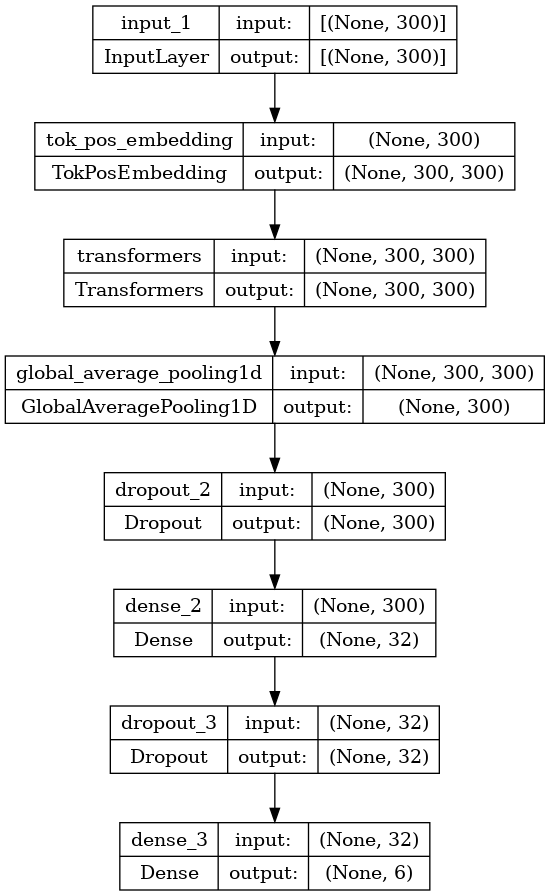

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Padding sequences in train and test, to have equal token lengths

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_seqs(texts, max_len):
    text_seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_seqs,maxlen=max_len)

train_seqs = preprocess_seqs(train_X,max_len)
test_seqs = preprocess_seqs(test_X,max_len)
    

In [20]:
train_seqs

array([[     0,      0,      0, ...,    196,    335, 106002],
       [     0,      0,      0, ...,      5,   2259,    510],
       [     0,      0,      0, ...,  15090,   3232,    303],
       ...,
       [     0,      0,      0, ...,     10,    431,   1872],
       [     0,      0,      0, ...,   6025,     17,    438],
       [     0,      0,      0, ...,     12,     20,    744]], dtype=int32)

## Training the model

In [21]:
model.fit(train_seqs,train_y)

3740/3740 [==============================] - 133s 33ms/step - loss: 0.1132 - acc: 0.9047


## Testing the model

In [22]:
print(model.evaluate(test_seqs,test_y))

1247/1247 [==============================] - 17s 13ms/step - loss: 0.0981 - acc: 0.9932
[0.09806877374649048, 0.9932318925857544]


In [27]:
preds = model.predict(test_seqs)

1247/1247 [==============================] - 16s 13ms/step


In [23]:
test_2d = test_y.values

In [24]:
test_2d

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

## Results - Metrics evaluation on test set

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [28]:
# Convert probability predictions to binary predictions (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.7
binary_preds = np.array(preds) > threshold

In [29]:
binary_preds = binary_preds.astype(int)

In [30]:
# Flatten the 2D arrays to 1D
test_flat = np.array(test_2d).flatten()
binary_preds_flat = binary_preds.flatten()

In [31]:
# Calculate Accuracy
accuracy = accuracy_score(test_flat, binary_preds_flat)
print("Accuracy:", accuracy)

Accuracy: 0.9653030189089147


In [32]:
test_2d_t = test_2d.T
bin_preds_t = binary_preds.T

## Results
1. **Global Accuracy score**: 0.9653030189089147
5. **Micro ROC AUC Score**: 0.7273566968485117
6. **Macro ROC AUC Score**: 0.5132840671810954


In [33]:
c=0
for i,j in zip(test_2d_t, bin_preds_t):
    precision = precision_score(i, j, average='weighted', zero_division = 0)
    recall = recall_score(i, j, average='weighted', zero_division = 0)
    f1 = f1_score(i, j, average='weighted', zero_division = 0)
    print(f"Class {c + 1} - {test_y.columns[c]}: Precision={precision}, Recall={recall}, F1 Score={f1}")
    c+=1

Class 1 - toxic: Precision=0.9259751932108378, Recall=0.9209635775699998, F1 Score=0.8964010869722494
Class 2 - severe_toxic: Precision=0.9797491277410624, Recall=0.989822775925601, F1 Score=0.9847601902991737
Class 3 - obscene: Precision=0.8940256398610372, Recall=0.9455292908530318, F1 Score=0.9190564686579918
Class 4 - threat: Precision=0.9932433471302208, Recall=0.9966159476599905, F1 Score=0.9949267892949467
Class 5 - insult: Precision=0.8993902326705538, Recall=0.9483618679968917, F1 Score=0.9232270939435042
Class 6 - identity_hate: Precision=0.9811390890882276, Recall=0.9905246534479734, F1 Score=0.9858095325659044


In [35]:
print("Micro ROC AUC Score\t",roc_auc_score(test_y,preds,average="micro"))
print("Macro ROC AUC Score\t",roc_auc_score(test_y,preds,average="macro"))

Micro ROC AUC Score	 0.7273566968485117
Macro ROC AUC Score	 0.5132840671810954
